In [1]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers as L
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from sklearn.model_selection import StratifiedKFold
import pandas as pd
from matplotlib import pyplot as plt

/home/jaidevd/conda/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/jaidevd/conda/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
base = InceptionV3(include_top=False)

base.trainable = False
inputs = L.Input(shape=(224, 224, 3))
x = base(inputs, training=False)
x = L.GlobalAveragePooling2D()(x)
outputs = L.Dense(5)(x)

87916544/87910968 [==============================] - 14s 0us/step


In [3]:
model = Model(inputs, outputs)
model.compile(Adam(), loss=CategoricalCrossentropy(from_logits=True), metrics=[CategoricalAccuracy()])
model.save_weights('checkpoints/inceptionv3_default.h5')

In [4]:
df = pd.read_csv('data/train.csv')
df = df[~df['path'].str.endswith('.gif')]

In [5]:
histories = []

for i, (trix, tsix) in enumerate(StratifiedKFold(n_splits=4).split(df, df['class'])):
    train_gen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        width_shift_range=[-60, 60], height_shift_range=[-60, 60],
        horizontal_flip=True, vertical_flip=True,
        zoom_range=[0.5, 1.5]
    ).flow_from_dataframe(df.iloc[trix], x_col='path', target_size=(224, 224), validate_filenames=False)
    test_gen = ImageDataGenerator(
        preprocessing_function=preprocess_input
    ).flow_from_dataframe(df.iloc[tsix], x_col='path', target_size=(224, 224), validate_filenames=False)
    model.load_weights('checkpoints/inceptionv3_default.h5')
    h = model.fit(
        train_gen, validation_data=test_gen, epochs=100,
        callbacks=[EarlyStopping(min_delta=0.01, patience=30, restore_best_weights=True)],
        verbose=2
    )
    model.save(f'checkpoints/inceptionv3_fold_{i}.h5')
    pd.DataFrame.from_dict(h.history).to_csv(f'checkpoints/inceptionv3_fold_{i}_history.csv', index=False)

Found 289 non-validated image filenames belonging to 5 classes.
Found 97 non-validated image filenames belonging to 5 classes.
Epoch 1/100


/home/jaidevd/conda/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


10/10 - 14s - loss: 1.5222 - categorical_accuracy: 0.3564 - val_loss: 1.0569 - val_categorical_accuracy: 0.6495
Epoch 2/100
10/10 - 9s - loss: 1.0318 - categorical_accuracy: 0.6125 - val_loss: 0.8177 - val_categorical_accuracy: 0.7423
Epoch 3/100
10/10 - 9s - loss: 0.8948 - categorical_accuracy: 0.6817 - val_loss: 0.6719 - val_categorical_accuracy: 0.7423
Epoch 4/100
10/10 - 9s - loss: 0.7182 - categorical_accuracy: 0.7924 - val_loss: 0.6403 - val_categorical_accuracy: 0.7732
Epoch 5/100
10/10 - 9s - loss: 0.7452 - categorical_accuracy: 0.7578 - val_loss: 0.5201 - val_categorical_accuracy: 0.8351
Epoch 6/100
10/10 - 9s - loss: 0.6233 - categorical_accuracy: 0.8028 - val_loss: 0.4613 - val_categorical_accuracy: 0.8557
Epoch 7/100
10/10 - 9s - loss: 0.6354 - categorical_accuracy: 0.7855 - val_loss: 0.4765 - val_categorical_accuracy: 0.8763
Epoch 8/100
10/10 - 9s - loss: 0.6821 - categorical_accuracy: 0.7716 - val_loss: 0.4277 - val_categorical_accuracy: 0.8454
Epoch 9/100
10/10 - 9s - lo

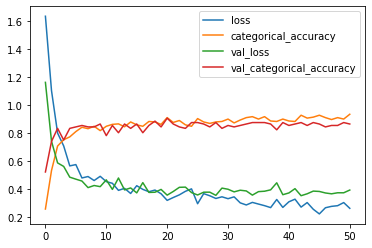

In [6]:
for k, v in h.history.items():
    plt.plot(v, label=k)
plt.legend()